# Final Project Check-in 2018-11-16

## Group Name: Lambda

### Student Names
1. Jian Wang
2. Chong Geng
3. Alan Perry
4. Divya Bhargavi
5. Robert Sandor

## Load Data

In [1]:
from collections import defaultdict
from math import sqrt
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import operator
import re
from scipy import spatial
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import string
import time

In [2]:
modified_train = pd.read_csv('combined.csv', encoding='ISO-8859-1')
modified_train.drop(columns=['Unnamed: 0']).head(1)

,index,product_uid,product_title,search_term,relevance,id,product_description,cleaned_terms,stemmed_terms,stemmed_title,...,stemmed_terms_in_title,stemmed_terms_in_desc,lemmatized_terms_in_title,lemmatized_terms_in_desc,neighbours_in_title,neighbours_in_desc,search_term_in_attrib,color_in_search_term,min_levenstein_dist_title,min_levenstein_dist_brand
0,0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,2,"Not only do angles make joints stronger, they ...",angle bracket,angl bracket,simpson strong tie gaug angl,...,1.0,1.0,1.0,1.0,0.0,1.0,1,0,10.0,0.001


## Fit scikit-learn model

In [3]:
# choice 1
X_train = modified_train[['clean_length', 'title_length', 
                          'desc_length', 'clean_terms_in_title', 
                          'clean_terms_in_desc', 'stemmed_terms_in_title',
                          'stemmed_terms_in_desc','lemmatized_terms_in_title',
                          'lemmatized_terms_in_desc','neighbours_in_title',
                         'neighbours_in_desc','min_levenstein_dist_brand',
                          'min_levenstein_dist_title','color_in_search_term',
                         'search_term_in_attrib','neighbours_in_desc',
                         'neighbours_in_title', 'lemmatized_terms_in_desc',]]
y_train = modified_train[['relevance']]

In [4]:
# since we can't see the relevancy scores of the test set,
# I decided to split the training set 
train_data, test_data, train_target, test_target = train_test_split(X_train,
                                                                        y_train, random_state=42)

In [5]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(train_data, train_target)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [6]:
predicted = lin_reg_model.predict(test_data)
print(predicted[:5])
print(test_target[:5])

[[2.02337346]
 [2.19124392]
 [2.32077374]
 [2.65426502]
 [2.69076532]]
       relevance
13534       3.00
29748       2.67
20225       2.67
5169        2.67
49860       2.00


## Evaluation Metric

In [20]:
# since an RMSE function couldn't be found quickly in the sklearn library,
# we just used the MSE function and took the square root of that
def rmse_lin_reg(model,x,test_target):
    return(sqrt(mean_squared_error(model.predict(x), test_target)))
def top_ten_rmse(model,x,test_target):
    #convert to numpy arrays
    predicted = model.predict(x)
    predicted = np.array(predicted)
    test_target = np.array(test_target)
    #find locations of top ten in predicted
    predicted_sort =  np.argsort(predicted)[::-1] #most relavent
    
    # find rmse of top relevent
    rmse_top_ten = np.sqrt(np.mean(np.square(predicted[predicted_sort[:10]] - test_target[predicted_sort[:10]])))
    return(rmse_top_ten)

# this value is equivalent to rank 1680 on the Kaggle leaderboard for this competition
# the benchmark was ~ rank 1681
# https://www.kaggle.com/c/home-depot-product-search-relevance/leaderboard
#print(f"{rmse_lin_reg:.4f}")

In [8]:
train_data.columns


Index(['clean_length', 'title_length', 'desc_length', 'clean_terms_in_title',
       'clean_terms_in_desc', 'stemmed_terms_in_title',
       'stemmed_terms_in_desc', 'lemmatized_terms_in_title',
       'lemmatized_terms_in_desc', 'neighbours_in_title', 'neighbours_in_desc',
       'min_levenstein_dist_brand', 'min_levenstein_dist_title',
       'color_in_search_term', 'search_term_in_attrib', 'neighbours_in_desc',
       'neighbours_in_title', 'lemmatized_terms_in_desc'],
      dtype='object')

Random Forrest

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import cross_val_score

make grid object
assign variabls 
plot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


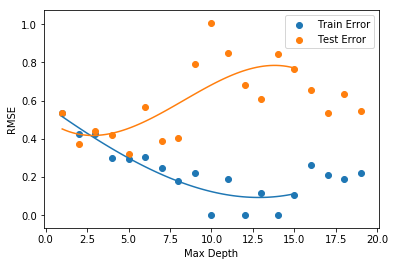

In [51]:
estimator_list = [('random_forrest', RandomForestRegressor())]
random_forrest__n_estimators=[2]
random_forrest__max_depth=range(1,20)
parameter_list = [
                  {'random_forrest__n_estimators':random_forrest__n_estimators,
                   'random_forrest__max_depth': random_forrest__max_depth
                  }
                ]
best_model = GridSearchCV(LinearRegression(),{},cv=5)

grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                   refit=True, 
                    scoring=top_ten_rmse,
                    cv=2)
grid.fit(train_data, np.array(train_target).ravel())

mean_test_score = []
mean_train_score = []
random_forrest__max_depth = []
for param in grid.cv_results_['params']:
    random_forrest__max_depth.append(param['random_forrest__max_depth'])
mean_train_score= grid.cv_results_['mean_train_score']
mean_test_score= grid.cv_results_['mean_test_score']

_, ax = plt.subplots(1,1)
s = UnivariateSpline(random_forrest__max_depth, mean_train_score,s=5)
x_train = np.linspace(1, 21, 100)
y_train = s(x_train)

s = UnivariateSpline(random_forrest__max_depth, mean_test_score,s=5)
x_test = np.linspace(1, 21, 100)
y_test = s(x_test)
ax.scatter(random_forrest__max_depth,mean_train_score,label='Train Error')
plt.plot(x_train[:70], y_train[:70])

plt.plot(x_test[:70], y_test[:70])
ax.scatter(random_forrest__max_depth,mean_test_score,label="Test Error")
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig('forrest_max_feature_error.png')
plt.show()

In [ ]:
make grid
assign vriables 
plot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


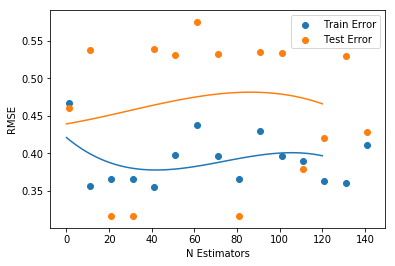

In [67]:
estimator_list = [('random_forrest', RandomForestRegressor())]
random_forrest__max_depth=[2]
random_forrest__n_estimators=range(1,151,10)
parameter_list = [
    
              {'random_forrest__n_estimators': random_forrest__n_estimators,
                    'random_forrest__max_depth': random_forrest__max_depth}
                ]
best_model = GridSearchCV(LinearRegression(),{},cv=5)

grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                   refit=True, 
                    scoring=top_ten_rmse,
                    cv=2)
grid.fit(train_data, np.array(train_target).ravel())
random_forrest__n_estimators = []
std_train_score = []
for param in grid.cv_results_['params']:
    random_forrest__n_estimators.append(param['random_forrest__n_estimators'])
std_train_score= grid.cv_results_['std_train_score']
mean_train_score= grid.cv_results_['mean_train_score']
std_train_score= grid.cv_results_['std_train_score']
mean_test_score= grid.cv_results_['mean_test_score']

_, ax = plt.subplots(1,1)
s = UnivariateSpline(random_forrest__n_estimators, mean_train_score, s=5)
x_train = np.linspace(0, 120, 100)
y_train = s(x_train)

s = UnivariateSpline(random_forrest__n_estimators, mean_test_score, s=5)
x_test = np.linspace(0, 120, 100)
y_test = s(x_test)
ax.scatter(random_forrest__n_estimators,mean_train_score,label='Train Error')
plt.plot(x_train, y_train)
ax.scatter(random_forrest__n_estimators,mean_test_score,label="Test Error")
plt.plot(x_test, y_test)

plt.xlabel('N Estimators')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig('forrest_n_estimator_error.png')
plt.show()

Make grid Object 
assign variables
graph

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


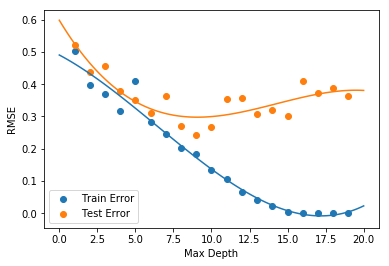

In [65]:
estimator_list = [('random_forrest', RandomForestRegressor())]
random_forrest__n_estimators=[8]
random_forrest__max_depth=range(1,20)
parameter_list = [{
                'random_forrest__n_estimators':random_forrest__n_estimators ,
                'random_forrest__max_depth': random_forrest__max_depth,
                'random_forrest__max_features':[4],
    'random_forrest__min_samples_split':[2],
                }]
best_model = GridSearchCV(LinearRegression(),{},cv=2)

grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                   refit=True, 
                    scoring=top_ten_rmse,
                    cv=5)
grid.fit(train_data, np.array(train_target).ravel())

random_forrest__max_depth = []
std_train_score = []
for param in grid.cv_results_['params']:
    random_forrest__max_depth.append(param['random_forrest__max_depth'])
mean_train_score= grid.cv_results_['mean_train_score']
mean_test_score= grid.cv_results_['mean_test_score']
    #rmse_list = np.array(rmse_list)
    #rmse_list.reshape(2,len(grid.cv_results_['split1_test_score']))
s = UnivariateSpline(random_forrest__max_depth, mean_train_score, s=5)
x_train = np.linspace(0, 20, 100)
y_train = s(x_train)

t = UnivariateSpline(random_forrest__max_depth, mean_test_score, s=5)
x_test = np.linspace(0, 20, 100)
y_test = t(x_test)

    
    
_, ax = plt.subplots(1,1)
ax.scatter(random_forrest__max_depth,mean_train_score,label="Train Error")


plt.plot(x_train, y_train)

plt.plot(x_test, y_test)

ax.scatter(random_forrest__max_depth,mean_test_score,label="Test Error")
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.savefig('forrest_max_depth_error.png')

plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

make grid object

Make grid Object

In [ ]:

estimator_list = [('gbr', GradientBoostingRegressor())]

parameter_list = [{
                'gbr__n_estimators': [1],
    'gbr__max_features':[7]   ,         
    'gbr__max_depth':range(1,20),
                'gbr__learning_rate':[0.01],
                'gbr__min_samples_split':[2],
                }]
best_model = GridSearchCV(LinearRegression(),{},cv=5)
rmse_list = []
grid = GridSearchCV(estimator=Pipeline(estimator_list), 
                    param_grid=parameter_list, 
                    refit=True, 
                    scoring=top_ten_rmse,
                    cv=5)
grid.fit(train_data, np.array(train_target).ravel())
predicted= grid.predict(test_data)


Assign variables

In [ ]:
rmse_list = []
random_forrest__max_depth = []
random_forrest__max_features = []
random_forrest__n_estimators = []
std_train_score = []
for param in grid.cv_results_['params']:
    random_forrest__max_depth.append(param['gbr__max_depth'])
    random_forrest__max_features.append(param['gbr__max_features'])
    random_forrest__n_estimators.append(param['gbr__n_estimators'])
std_train_score= grid.cv_results_['std_train_score']
mean_train_score= grid.cv_results_['mean_train_score']
std_train_score= grid.cv_results_['std_train_score']
mean_test_score= grid.cv_results_['mean_test_score']
    #rmse_list = np.array(rmse_list)
    #rmse_list.reshape(2,len(grid.cv_results_['split1_test_score']))

#print(rmse_list)



#for postfix in ['.png','.pdf']:
#    name = 'greRMSE'+postfix
#plt.savefig(name,bbox_inches='tight')


graph

In [ ]:
plt.figure(figsize=(12, 6))
_, ax = plt.subplots(1,1)
ax.scatter(random_forrest__max_depth,mean_train_score,label="Train Error")

ax.scatter(random_forrest__max_depth,mean_test_score,label="Test Error")
s = UnivariateSpline(random_forrest__max_depth, mean_train_score, s=5)
x_train = np.linspace(0, 20, 100)
y_train = s(x_train)

t = UnivariateSpline(random_forrest__max_depth, mean_test_score, s=5)
x_test = np.linspace(0, 20, 100)
y_test = t(x_test)

plt.plot(x_train, y_train)

plt.plot(x_test, y_test)

plt.xlabel('Max Features')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.savefig('GBR_max_depth_error.png')

plt.show()